## Preparing the environment

In [1]:
import os
import random
import numpy as np

import torch
from torch.utils.data import DataLoader

from datasets import load_dataset, Dataset
import transformers
from accelerate import Accelerator

from tqdm import tqdm

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

data_path = "../data"
models_path = "../models"

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False

#### Setting constants

In [3]:
context_length = 128

batch_size = 128
num_workers = 8
global_batch_size = 512
accumulation_steps = global_batch_size // batch_size

learning_rate = 3e-4
betas = (0.9, 0.95)
eps = 1e-8
gradient_clipping = 1.0
weight_decay = 0.1

warmup_iters = 250

train_iters = 2000
eval_save_interval = 50
save_iters = [500]
val_iters = 20

model_name = "EleutherAI/pythia-14m"
model_revision = "step0"

dataset_path = "allenai/c4"
dataset_name = "realnewslike"

## Loading dataset

In [4]:
dataset = load_dataset(dataset_path, dataset_name)
dataset = dataset.with_format("torch")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, revision=model_revision)

def tokenize(data):
    outputs = tokenizer(
        data["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = list()
    # deleting samples shorter than context_length tokens
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
if os.path.exists(os.path.join(data_path, "train_dataset")):
    train_dataset = Dataset.load_from_disk(os.path.join(data_path, "train_dataset"))
else:
    train_dataset = dataset["train"].map(
        tokenize, batched=True, remove_columns=dataset["train"].column_names
    )
    train_dataset.save_to_disk(os.path.join(data_path, "train_dataset"))


if os.path.exists(os.path.join(data_path, "val_dataset")):
    val_dataset = Dataset.load_from_disk(os.path.join(data_path, "val_dataset"))
else:
    val_dataset = dataset["validation"].map(
        tokenize, batched=True, remove_columns=dataset["validation"].column_names
    )
    val_dataset.save_to_disk(os.path.join(data_path, "val_dataset"))

Loading dataset from disk:   0%|          | 0/58 [00:00<?, ?it/s]

In [7]:
val_dataset = val_dataset.select(range(len(val_dataset) // (batch_size * val_iters) * (batch_size * val_iters)))

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Training

### Full-rank Training

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              worker_init_fn=seed_worker,
                              generator=g)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers,
                            worker_init_fn=seed_worker,
                            generator=g,
                            drop_last=True)

In [10]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name,
                                                          revision=model_revision,
                                                          attn_implementation="flash_attention_2").to(device)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)

scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_iters, num_training_steps=train_iters)

In [12]:
accelerator = Accelerator(mixed_precision="fp16")

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

In [13]:
def evaluate(model, val_dataloader, val_iters):
    model.eval()
    val_losses = list()
    for step, batch in enumerate(val_dataloader):
        with torch.inference_mode():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])
            val_losses.append(outputs.loss.item())
        if step + 1 >= val_iters:
            break
    val_loss = np.mean(val_losses)
    return val_loss

In [14]:
model.train()
train_losses = dict()
val_losses = dict()
last_losses = list()
completed_steps = 0

for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=int(train_iters * accumulation_steps)
    ):
    output = model(batch["input_ids"], labels=batch["input_ids"])
    loss = output.loss
    last_losses.append(loss.item())
    loss /= accumulation_steps
    accelerator.backward(loss)
    
    if step % accumulation_steps == 0:
        accelerator.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    
    if step % (eval_save_interval * accumulation_steps) == 0:
        train_losses[completed_steps] = np.mean(last_losses)
        val_losses[completed_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[completed_steps],
                "loss/val": val_losses[completed_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
        if completed_steps in save_iters:
            unwrapped_model = accelerator.unwrap_model(model)
            save_path = os.path.join(models_path, model_name.split('/')[-1] + f"_{completed_steps}_of_{train_iters}")
            unwrapped_model.save_pretrained(save_path, save_function=accelerator.save)

    if completed_steps >= train_iters:
        accelerator.wait_for_everyone()
        break

  3%|▎         | 202/8000 [00:20<25:10,  5.16it/s]

{'steps': 50, 'loss/train': 10.699462862014771, 'loss/val': 10.255578804016114}


  5%|▌         | 402/8000 [00:37<24:31,  5.16it/s]

{'steps': 100, 'loss/train': 9.872554206848145, 'loss/val': 9.44077639579773}


  8%|▊         | 602/8000 [00:55<26:10,  4.71it/s]

{'steps': 150, 'loss/train': 8.962931571006775, 'loss/val': 8.448394536972046}


 10%|█         | 802/8000 [01:12<23:52,  5.02it/s]

{'steps': 200, 'loss/train': 7.988281383514404, 'loss/val': 7.569437623023987}


 13%|█▎        | 1002/8000 [01:30<22:53,  5.10it/s]

{'steps': 250, 'loss/train': 7.277792427539826, 'loss/val': 7.048223209381104}


 15%|█▌        | 1202/8000 [01:47<21:58,  5.16it/s]

{'steps': 300, 'loss/train': 6.8740458178520205, 'loss/val': 6.72865355014801}


 18%|█▊        | 1402/8000 [02:04<21:22,  5.14it/s]

{'steps': 350, 'loss/train': 6.6124922156333925, 'loss/val': 6.504604244232178}


 20%|██        | 1602/8000 [02:22<20:58,  5.08it/s]

{'steps': 400, 'loss/train': 6.424008157253265, 'loss/val': 6.341244888305664}


 23%|██▎       | 1802/8000 [02:39<20:05,  5.14it/s]

{'steps': 450, 'loss/train': 6.301475169658661, 'loss/val': 6.256803512573242}


 25%|██▌       | 2000/8000 [02:57<27:18,  3.66it/s]

{'steps': 500, 'loss/train': 6.196291525363922, 'loss/val': 6.184853911399841}


 28%|██▊       | 2202/8000 [03:14<18:37,  5.19it/s]

{'steps': 550, 'loss/train': 6.1192137193679805, 'loss/val': 6.07482213973999}


 30%|███       | 2402/8000 [03:31<17:55,  5.20it/s]

{'steps': 600, 'loss/train': 6.0507206130027775, 'loss/val': 6.01316192150116}


 33%|███▎      | 2602/8000 [03:48<17:15,  5.21it/s]

{'steps': 650, 'loss/train': 5.987436573505402, 'loss/val': 5.985657382011413}


 35%|███▌      | 2802/8000 [04:06<16:54,  5.12it/s]

{'steps': 700, 'loss/train': 5.939016592502594, 'loss/val': 5.917293810844422}


 38%|███▊      | 3002/8000 [04:23<16:22,  5.09it/s]

{'steps': 750, 'loss/train': 5.889787857532501, 'loss/val': 5.885987663269043}


 40%|████      | 3202/8000 [04:40<15:32,  5.15it/s]

{'steps': 800, 'loss/train': 5.856875684261322, 'loss/val': 5.8275063037872314}


 43%|████▎     | 3402/8000 [04:57<15:31,  4.93it/s]

{'steps': 850, 'loss/train': 5.812206287384033, 'loss/val': 5.805680274963379}


 45%|████▌     | 3602/8000 [05:15<14:22,  5.10it/s]

{'steps': 900, 'loss/train': 5.774637191295624, 'loss/val': 5.782378196716309}


 48%|████▊     | 3802/8000 [05:32<13:33,  5.16it/s]

{'steps': 950, 'loss/train': 5.750528681278229, 'loss/val': 5.75179693698883}


 50%|█████     | 4002/8000 [05:49<12:59,  5.13it/s]

{'steps': 1000, 'loss/train': 5.722039067745209, 'loss/val': 5.715977740287781}


 53%|█████▎    | 4202/8000 [06:07<12:39,  5.00it/s]

{'steps': 1050, 'loss/train': 5.702205672264099, 'loss/val': 5.713382196426392}


 55%|█████▌    | 4402/8000 [06:24<11:30,  5.21it/s]

{'steps': 1100, 'loss/train': 5.674367122650146, 'loss/val': 5.69276533126831}


 58%|█████▊    | 4602/8000 [06:42<11:08,  5.08it/s]

{'steps': 1150, 'loss/train': 5.648911075592041, 'loss/val': 5.653667044639588}


 60%|██████    | 4802/8000 [06:59<10:13,  5.21it/s]

{'steps': 1200, 'loss/train': 5.638859317302704, 'loss/val': 5.661372542381287}


 63%|██████▎   | 5002/8000 [07:16<09:34,  5.22it/s]

{'steps': 1250, 'loss/train': 5.619383044242859, 'loss/val': 5.630578637123108}


 65%|██████▌   | 5202/8000 [07:33<08:55,  5.23it/s]

{'steps': 1300, 'loss/train': 5.607493526935578, 'loss/val': 5.58692433834076}


 68%|██████▊   | 5402/8000 [07:50<08:14,  5.25it/s]

{'steps': 1350, 'loss/train': 5.585143103599548, 'loss/val': 5.574338269233704}


 70%|███████   | 5602/8000 [08:07<07:38,  5.23it/s]

{'steps': 1400, 'loss/train': 5.577269279956818, 'loss/val': 5.59282922744751}


 73%|███████▎  | 5802/8000 [08:24<07:03,  5.19it/s]

{'steps': 1450, 'loss/train': 5.576429648399353, 'loss/val': 5.5885097742080685}


 75%|███████▌  | 6002/8000 [08:41<06:29,  5.13it/s]

{'steps': 1500, 'loss/train': 5.559952733516693, 'loss/val': 5.57940821647644}


 78%|███████▊  | 6202/8000 [08:58<05:44,  5.22it/s]

{'steps': 1550, 'loss/train': 5.556984493732452, 'loss/val': 5.559482479095459}


 80%|████████  | 6402/8000 [09:15<05:20,  4.98it/s]

{'steps': 1600, 'loss/train': 5.548549273014069, 'loss/val': 5.550400590896606}


 83%|████████▎ | 6602/8000 [09:32<04:33,  5.11it/s]

{'steps': 1650, 'loss/train': 5.543554742336273, 'loss/val': 5.5613010168075565}


 85%|████████▌ | 6802/8000 [09:50<03:50,  5.19it/s]

{'steps': 1700, 'loss/train': 5.54236704826355, 'loss/val': 5.548907709121704}


 88%|████████▊ | 7002/8000 [10:07<03:10,  5.25it/s]

{'steps': 1750, 'loss/train': 5.533626408576965, 'loss/val': 5.5306649684906}


 90%|█████████ | 7202/8000 [10:24<02:35,  5.13it/s]

{'steps': 1800, 'loss/train': 5.537709932327271, 'loss/val': 5.541063737869263}


 93%|█████████▎| 7402/8000 [10:42<01:56,  5.11it/s]

{'steps': 1850, 'loss/train': 5.524736504554749, 'loss/val': 5.534623169898987}


 95%|█████████▌| 7602/8000 [10:59<01:19,  5.02it/s]

{'steps': 1900, 'loss/train': 5.533935332298279, 'loss/val': 5.533136701583862}


 98%|█████████▊| 7802/8000 [11:17<00:39,  5.04it/s]

{'steps': 1950, 'loss/train': 5.534563436508178, 'loss/val': 5.548049521446228}


100%|█████████▉| 7999/8000 [11:34<00:00, 11.52it/s]

{'steps': 2000, 'loss/train': 5.528219921588898, 'loss/val': 5.538971090316773}


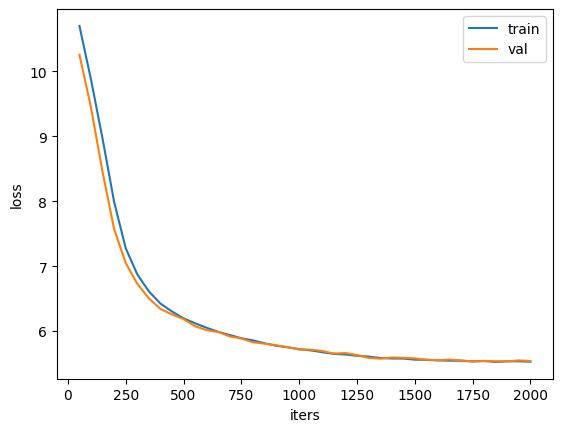

In [15]:
plt.plot(*zip(*train_losses.items()))
plt.plot(*zip(*val_losses.items()))
plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('iters')
plt.show()